In [0]:
! pip install comet-ml

In [0]:
! git clone https://github.com/dudeperf3ct/TextRecognizer.git

In [0]:
!pip install boltons wget

In [4]:
%cd TextRecognizer/Experiment-4/notebooks

/content/TextRecognizer/Experiment-4/notebooks


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [0]:
import sys
sys.path.append('..')

In [0]:
from src.paragraph_text_recognizer import ParagraphTextRecognizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

In [0]:
para_text_recognizer = ParagraphTextRecognizer()

In [0]:
import wget
#https://www.learnopencv.com/wp-content/uploads/2018/06/computer-vision.jpg
#https://miro.medium.com/max/331/1*l_9PU8XBr7uKBghAMtP2aw.png
print('[INFO] Download sample image...')
! wget "https://miro.medium.com/max/331/1*l_9PU8XBr7uKBghAMtP2aw.png" -P "/content"
! wget "https://www.learnopencv.com/wp-content/uploads/2018/06/computer-vision.jpg" -P "/content"

print ('[INFO] Download complete...')

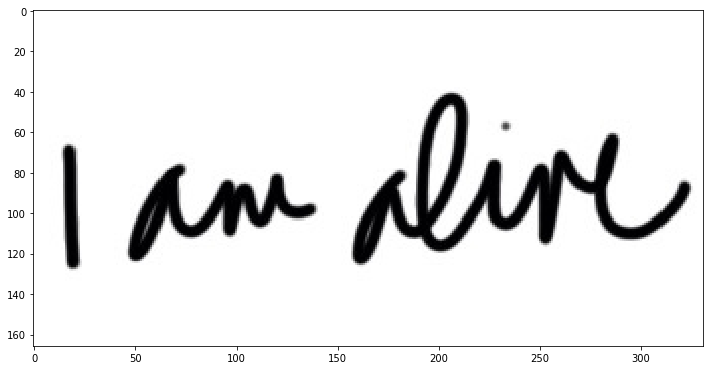

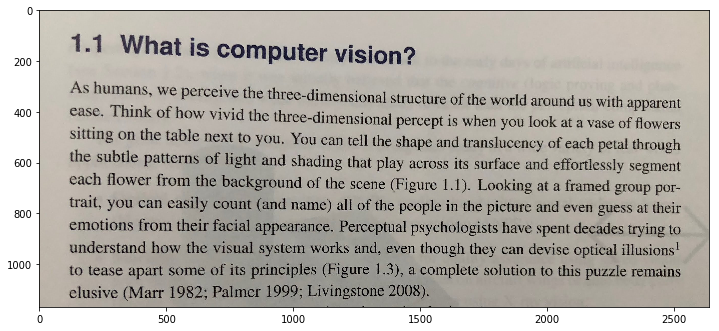

In [11]:
import imageio

image = imageio.imread("/content/1*l_9PU8XBr7uKBghAMtP2aw.png")
fig = plt.figure(figsize=(12, 18))
plt.imshow(image)
plt.show()

image = imageio.imread("/content/computer-vision.jpg")
fig = plt.figure(figsize=(12, 18))
plt.imshow(image)
plt.show()

In [55]:
%%writefile ../src/paragraph_text_recognizer.py

"""
Takes an image and returns all the text in it, by first segmenting the image with LineDetector, then extracting crops
of the image corresponding to the line regions, and running each line region crop through LinePredictor.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import List, Tuple, Union
import cv2
import numpy as np
import imageio
import imutils
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append(str(Path(__file__).resolve().parents[1]))
from src.data.iam_lines import IAMLines
from src.models.line_detect_model import LineDetectModel
from src.models.line_model_ctc import LineModelCTC
import keras
import tensorflow as tf

class ParagraphTextRecognizer:
    """Given an image of a single handwritten character, recognizes it."""
    def __init__(self):
        self.line_detector_model = LineDetectModel()
        self.line_detector_model.load_weights()
        args = {'backbone' : 'lenet', 'seq_model' : 'lstm', 'bi' : True}
        self.line_predictor_model = LineModelCTC(dataset=IAMLines, network_args=args)
        self.line_predictor_model.load_weights()

    def predict(self, image_or_filename: Union[np.ndarray, str]):
        """
        Takes an image and returns all the text in it.
        """
        if isinstance(image_or_filename, str):
            image = imageio.imread(image_or_filename, pilmode='L')
        else:
            image = image_or_filename

        line_region_crops = self.get_line_region_crops(image=image)
        #print([a.shape for a in line_region_crops])
        prepared_line_region_crops = [
            self.prepare_image_for_line_predictor_model(image=crop)
            for crop in line_region_crops
        ]
        print ('[INFO] Ideal output should be crops of each line from paragraph...')
        for crop in prepared_line_region_crops:
            fig = plt.figure(figsize=(12, 18))
            plt.imshow(crop, cmap='gray')
            plt.show()
        line_region_strings = [
            self.line_predictor_model.predict_on_image(crop)[0]
            for crop in prepared_line_region_crops
        ]
        return ' '.join(line_region_strings)

    def get_line_region_crops(self, image: np.ndarray, min_crop_len_factor: float = 0.02) -> List[np.ndarray]:
        """Find all the line regions in square image and crop them out and return them."""
        prepared_image, scale_down_factor = self.prepare_image_for_line_detector_model(image)
        # print ('[INFO] Cropped image...')        
        # plt.imshow(prepared_image)
        # plt.show()
        line_segmentation = self.line_detector_model.predict_on_image(prepared_image)
        # print ('[INFO] Segmented image...')        
        # plt.imshow(line_segmentation.argmax(-1), cmap='gray')
        # plt.show()
        bounding_boxes_xywh = find_line_bounding_boxes(line_segmentation)

        bounding_boxes_xywh = (bounding_boxes_xywh * scale_down_factor).astype(int)

        min_crop_length = int(min_crop_len_factor * min(image.shape[0], image.shape[1]))
        line_region_crops = [
            image[y:y+h, x:x+w]
            for x, y, w, h in bounding_boxes_xywh
            if w >= min_crop_length and h >= min_crop_length
        ]
        return line_region_crops

    def prepare_image_for_line_detector_model(self, image: np.ndarray) -> Tuple[np.ndarray, float]:
        """Convert uint8 image to float image with black background with shape self.line_detector_model.image_shape."""
        resized_image, scale_down_factor = resize_image_for_line_detector_model(
            image=image,
            max_shape=self.line_detector_model.image_shape
        )
        resized_image = (1. - resized_image / 255).astype('float32')
        return resized_image, scale_down_factor

    def prepare_image_for_line_predictor_model(self, image: np.ndarray) -> np.ndarray:
        """
        Convert uint8 image to float image with black background with shape self.line_predictor_model.image_shape
        while maintaining the image aspect ratio.
        """
        expected_shape = self.line_predictor_model.image_shape
        scale_factor = (np.array(expected_shape) / np.array(image.shape)).min()
        scaled_image = cv2.resize(image, dsize=None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

        pad_width = ((0, expected_shape[0] - scaled_image.shape[0]), (0, expected_shape[1] - scaled_image.shape[1]))
        padded_image = np.pad(scaled_image, pad_width=pad_width, mode='constant', constant_values=255)
        return 1 - padded_image / 255


def find_line_bounding_boxes(line_segmentation: np.ndarray):
    """Given a line segmentation, find bounding boxes for connected-component regions corresponding to non-0 labels."""

    def find_line_bounding_boxes_in_channel(line_segmentation_channel: np.ndarray) -> np.ndarray:
        line_activation_image = cv2.dilate(line_segmentation_channel, kernel=np.ones((3, 3)), iterations=1)
        line_activation_image = (line_activation_image * 255).astype('uint8')
        line_activation_image = cv2.threshold(line_activation_image, 0.5, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        # print ('[INFO] Thresholed image...')
        # plt.imshow(line_activation_image, cmap='gray')
        # plt.show()
        bounding_cnts = cv2.findContours(line_activation_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bounding_cnts = imutils.grab_contours(bounding_cnts)
        return np.array([cv2.boundingRect(cnt) for cnt in bounding_cnts])

    bboxes_xywh = np.concatenate([
        find_line_bounding_boxes_in_channel(line_segmentation[:, :, i])
        for i in [1, 2]
    ], axis=0)
    return bboxes_xywh[np.argsort(bboxes_xywh[:, 1])]


def resize_image_for_line_detector_model(image: np.ndarray, max_shape: Tuple[int, int]) -> Tuple[np.ndarray, float]:
    """Resize the image to less than the max_shape while maintaining aspect ratio."""
    scale_down_factor = max(np.array(image.shape) / np.array(max_shape))
    if scale_down_factor == 1:
        return image.copy(), scale_down_factor
    resized_image = cv2.resize(image,
                               dsize=None,
                               fx=1/scale_down_factor,
                               fy=1/scale_down_factor,
                               interpolation=cv2.INTER_AREA)
    return resized_image, scale_down_factor

Overwriting ../src/paragraph_text_recognizer.py


In [61]:
from src.data.iam_paragraphs import IAMPara
from src.models.line_detect_model import LineDetectModel

iam_para = IAMPara()
iam_para.load_data()
line_detector_model = LineDetectModel()

[INFO] Loading IAM paragraph crops and ground truth from image files...
[INFO] Arguments passed to data augmentation... {'width_shift_range': 0.06, 'height_shift_range': 0.1, 'horizontal_flip': True, 'zoom_range': 0.1, 'fill_mode': 'constant', 'cval': 0, 'shear_range': 3}


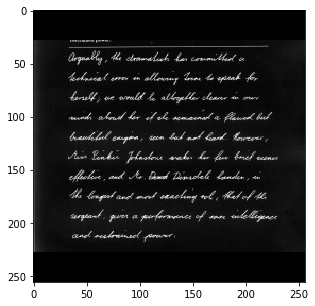

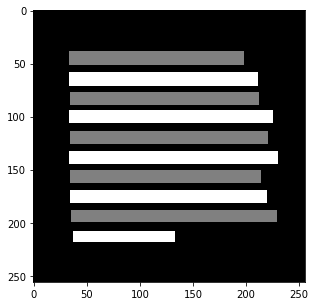

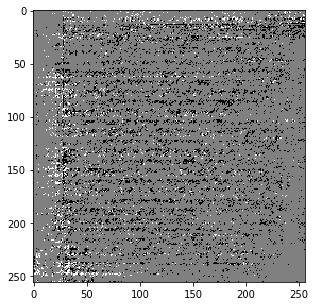

In [67]:
ind = 15

img = iam_para.x_test[ind]
fig = plt.figure(figsize=(10, 5))
plt.imshow(img, cmap='gray')

gt = iam_para.y_test[ind].argmax(-1)
fig = plt.figure(figsize=(10, 5))
plt.imshow(gt, cmap='gray')

pred = line_detector_model.predict_on_image(iam_para.x_test[ind]).argmax(-1)
fig = plt.figure(figsize=(10, 5))
plt.imshow(pred, cmap='gray')

In [0]:
para_text_recognizer.predict(img)

In [0]:
filename = '/content/computer-vision.jpg'
para_text_recognizer.predict(filename)